## Profile likelihood
To perform a basic profile likelihood analysis of a fit obtained, basico implements the [Schaber method](https://www.sciencedirect.com/science/article/pii/S0303264712001670) that in turn fixes each optimization parameter, while reoptimizing the remaining parameters. This scan is performed in both directions. Ideally, what we would want to see for identified parameters, is that the result gets worse, as we go away from the found solution. If we find a flat line, that means the parameter is not identifiable, if we find a curve that is flat on one side, we can only identify the corresponding bound.  

Since this could potentially take quite some time basico breaks this task into three steps: 

 * generating different copasi models for each of the scans. (these files could then be moved to a cluster environment for parallel computation)
 * running the the scans (here basico uses the python mulitiprocessing library), which places reports into a specified directory
 * plotting the result, by specifying the directory where the reports have been stashed. 
 
Let's try this on an example model.

In [1]:
from basico import * 
from basico.task_profile_likelihood import prepare_files, process_dir, plot_data

### Preparing files
The first step is to prepare the files, here we load an example model, run the parameter estimation

In [2]:
example_model = load_example('LM')
run_parameter_estimation(update_model=True)

,lower,upper,sol,affected
name,,,,
(R1).k2,1e-6,1e6,0.000002,[]
(R2).k1,1e-6,1e6,44.661715,[]
Values[offset],-0.2,0.4,0.043018,[Experiment_1]
Values[offset],-0.2,0.4,0.054167,[Experiment_3]
Values[offset],-0.2,0.4,-0.050941,[Experiment]
Values[offset],-0.2,0.4,0.045922,[Experiment_4]
Values[offset],-0.2,0.4,0.048025,[Experiment_2]


now we create a temporary directory, and save the file and experimental data into it. After that i unload the model.

In [3]:
from tempfile import mkdtemp
data_dir = mkdtemp()
original_model = os.path.join(data_dir, 'original.cps')
save_model(original_model)
remove_datamodel(example_model)

the code has just been ported from an earlier version, so lets debug it for now

In [4]:
#import logging
#logging.basicConfig()
#logging.getLogger().setLevel(logging.DEBUG)

the data will be stored in those files: 

In [5]:
#print(data_dir)
#print(original_model)

now we go ahead and prepare all the files, this is done by the `prepare_files` function that accepts the following arguments: 

* `filename`: the template file with the fit we want to analyze
* `data_dir`: the directory in which to store the files in

the remaining parameters are optional: 

* `iterations=50`: if not specified hooks & Jeeves / Levenberg Marquardt will perform `50` iterations
* `scan_interval=40`: if not specified 40 scan intervals will be taken (40 in each direction!)
* `lower_multiplier=0.5`: the multiplier for the lower bound of the scan. By default the interval will be 50% of the found parmeter value. 
* `upper_multiplier=2.0`: the multiplier for the upper bound of the scan, defaults to twice the value found
* `modulation=0.01`: modulation parameter for Levenberg Marquardt
* `tolerance=1e-06`: tolerance for the optimization method
* `disable_plots=True`: if true, other plots in the file will be removed
* `disable_tasks=True`: if true, other tasks in the file will be deleted
* `use_hooke=False`: if true, use hooks & jeaves otherwise Levenberg Marquadt
* `prefix="out_"`: the prefix for each file generated.

For this example we just do a scan of 8 values in each direction for 20 iterations: 

In [6]:
prepare_files(original_model, scan_interval=8, iterations=20, data_dir=data_dir)

### Processing the files: 
Here we use the python multiprocessing pool, to launch `CopasiSE` to process all the files we have generated in the data directory we process 4 files at the same time, but you can supply a `pool_size` parameter to change that. This step can be skipped, if you copy the files to a cluster environment and run them there. 

In [7]:
process_dir(data_dir)

### Looking at the results
The `plot_data` function reads all the report files from the `data_dir`, and combines the scans from both directions to one plot. 

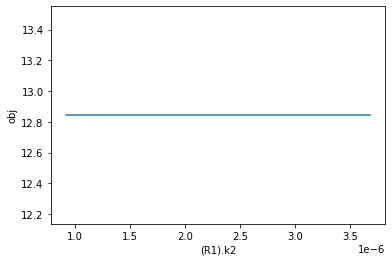

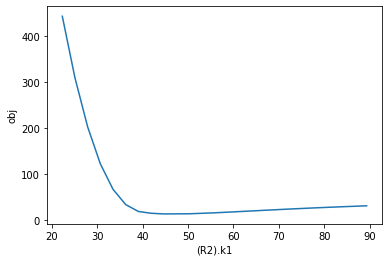

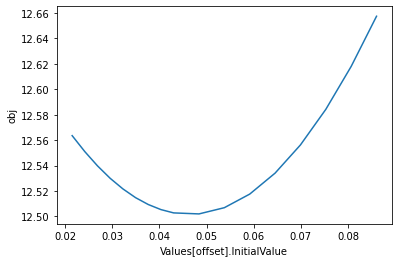

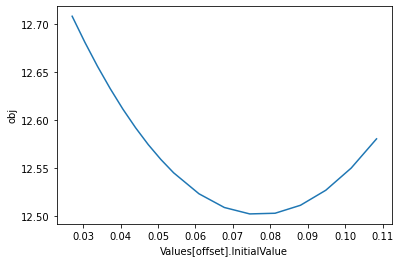

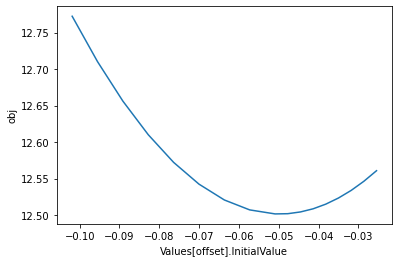

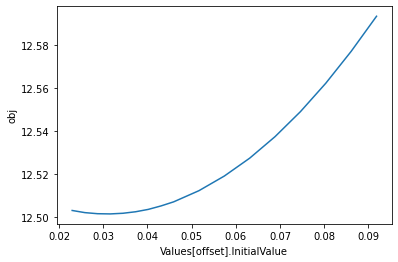

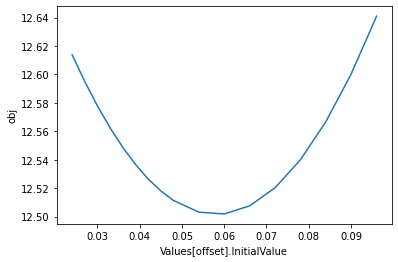

In [8]:
plots = plot_data(data_dir)

and finally, let us remove the temporary files: 

In [9]:
#import shutil
#shutil.rmtree(data_dir, ignore_errors=True)